In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from rlway.pyosrd.osrd import OSRD

In [22]:
sim = OSRD(use_case='point_switch', dir='tmp')

[07:44:16,910] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp/infra.json
[07:44:16,942] [INFO]              [FullInfra] parsing infra
[07:44:17,002] [INFO]              [FullInfra] adaptation to kotlin
[07:44:17,033] [INFO]              [FullInfra] loading signals
[07:44:17,039] [INFO]              [FullInfra] building blocks
[07:44:17,044] [INFO]  [StandaloneSimulationCommand] Loading input: tmp/simulation.json
[07:44:17,058] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.4
[07:44:17,105] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.5
[07:44:17,110] [INFO]  [StandaloneSimulationCommand] All simulations completed
[07:44:17,110] [INFO]  [StandaloneSimulationCommand] Saving results at: tmp/results.json


In [23]:
!mkdir -p tmp/disturbed
!mkdir -p tmp/disturbed/regulated

In [24]:
sim._head_position(0)

def time_train_is_at_point_id(
    self,
    train: int,
    point_id: str,
    eco_or_base:str = 'base',
) -> float:
    """At what time a given train arrives at a given encountered point ?"""
    return [
        point[f't_{eco_or_base}']
        for point in self.points_encountered_by_train(train)
        if point['id'] == point_id
    ][0]

In [25]:
from rlway.pyosrd.osrd import OSRD

def add_delay(self: OSRD, train: int, point_id: str, delay: float) -> None:
    """Adds a delay to simulation results for a train after a given point

    Warning: route_occupancies are not updated

    Parameters
    ----------
    self : OSRD
       OSRD simulation object
    train : int
        train index
    point_id : str
        Point id
    delay : float
        Delay in seconds
    """

    time_threshold = time_train_is_at_point_id(self, train, point_id)
    print(time_threshold)
    group, idx = self._train_schedule_group[
        self.trains[train]
    ]

    for eco_or_base in ['eco', 'base']:
        sim = f'{eco_or_base}_simulations'

        dict = (
            self.results[group][sim][idx]
            if self.results[group][sim] != [None]
            else {}
        )
        for key, records in dict.items():
            if isinstance(records, list):
                for i, record in enumerate(records):
                    for subkey, value in record.items():
                        if 'time' in subkey and value >= time_threshold:
                            self.results[group][sim][idx][key][i][subkey] += \
                                delay


In [28]:
from copy import copy, deepcopy
import json
import os

disturbed = deepcopy(sim)
disturbed.simulation_json='disturbed/simulation.json'
disturbed.results_json='disturbed/results.json'
!mkdir -p tmp/disturbed

add_delay(disturbed, train=0, point_id='DVG', delay=120)
with open(os.path.join(disturbed.dir, disturbed.results_json), "w") as outfile:
    json.dump(disturbed.results, outfile)
# disturbed.run()


regulated = deepcopy(disturbed)
regulated.simulation_json='disturbed/regulated/simulation.json'
regulated.results_json='disturbed/regulated/results.json'
!mkdir -p tmp/disturbed/regulated
regulated.simulation['train_schedule_groups'][1]['schedules'][0]['stops']+=[{'duration': 150, 'position': 0.1}]
with open(os.path.join(regulated.dir, regulated.simulation_json), "w") as outfile:
    json.dump(regulated.simulation, outfile)
regulated.run()
add_delay(regulated, train=0, point_id='DVG', delay=120)

239.4798391107056
[07:45:08,621] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp/infra.json
[07:45:08,650] [INFO]              [FullInfra] parsing infra
[07:45:08,706] [INFO]              [FullInfra] adaptation to kotlin
[07:45:08,737] [INFO]              [FullInfra] loading signals
[07:45:08,742] [INFO]              [FullInfra] building blocks
[07:45:08,747] [INFO]  [StandaloneSimulationCommand] Loading input: tmp/disturbed/regulated/simulation.json
[07:45:08,758] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.4
[07:45:08,806] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.5
[07:45:08,810] [INFO]  [StandaloneSimulationCommand] All simulations completed
[07:45:08,810] [INFO]  [StandaloneSimulationCommand] Saving results at: tmp/disturbed/regulated/results.json
239.4798391107056


<Axes: title={'center': 'train1 (base)'}, xlabel='Time [min]'>

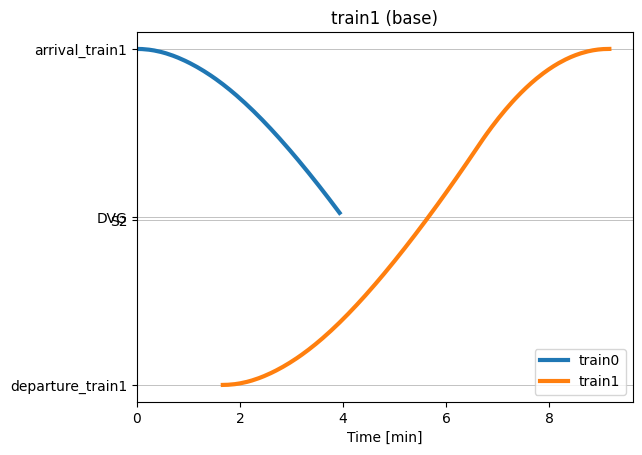

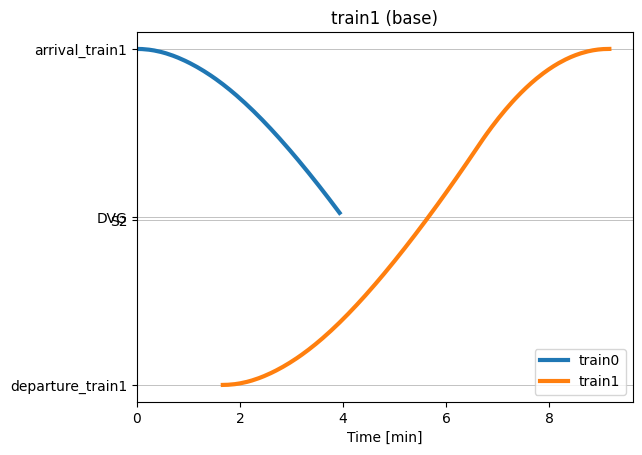

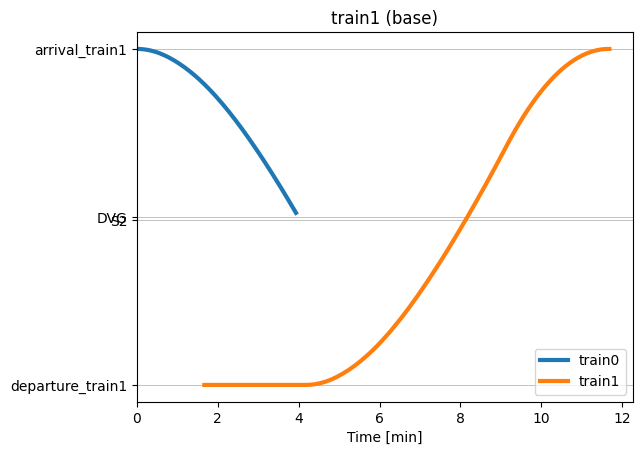

In [30]:
import matplotlib.pyplot as plt
points_to_show=['switch', 'signal', 'departure', 'switch', 'arrival']
sim.space_time_chart(1, points_to_show=points_to_show)
disturbed.space_time_chart(1, points_to_show=points_to_show)
regulated.space_time_chart(1, points_to_show=points_to_show)